In [ ]:
from reduction import start

start(file='modeled_data/defocus2000m_5_130.fits', 
      latency=4, 
      file_bias=None, 
      bin_factor=2, 
      D=2.5,
      data_dir='D:/astro/domecam',
      save_as='defocus2000m_5_130')

Fitting data/20210130m_m2km_corr_4_blur.gz...
Fitting stucked!
Total iterations: 26
time: 20.6984086

Fitting data/20210130m_0km_corr_4_blur.gz...
Done, thresh reached!
Total iterations: 24
time: 19.3788629

-------------------------------------------
File: data/20210130m_0km_corr_4_blur.gz
      Vx, m/s    Vy, m/s  Cn2, 1e-14      z, km
19  -3.657696   2.073631    0.356104   3.030191
6   -9.418432   5.963788    1.127571   4.545452
13  -6.691487   5.254425    0.474545   4.715729
8  -14.212358   9.124631    1.103516   5.079875
9   -4.775521   5.254425    0.561937   5.234366
7  -14.734166  11.438269    1.288626   5.309185
21 -17.699115  10.100792    0.459277   6.107377
20  -3.723410   5.254429    0.136683   6.230034
23 -11.061947  11.805927    0.279270   6.259914
4   -7.888998   5.321643    1.503154   6.292392
1   -5.911602   5.204037    2.211847   6.570099
18  -2.765487   3.622171    0.135854   6.895610
16 -11.350650   7.466815    0.218214  10.160128
5  -12.889566   7.822514    0.653701

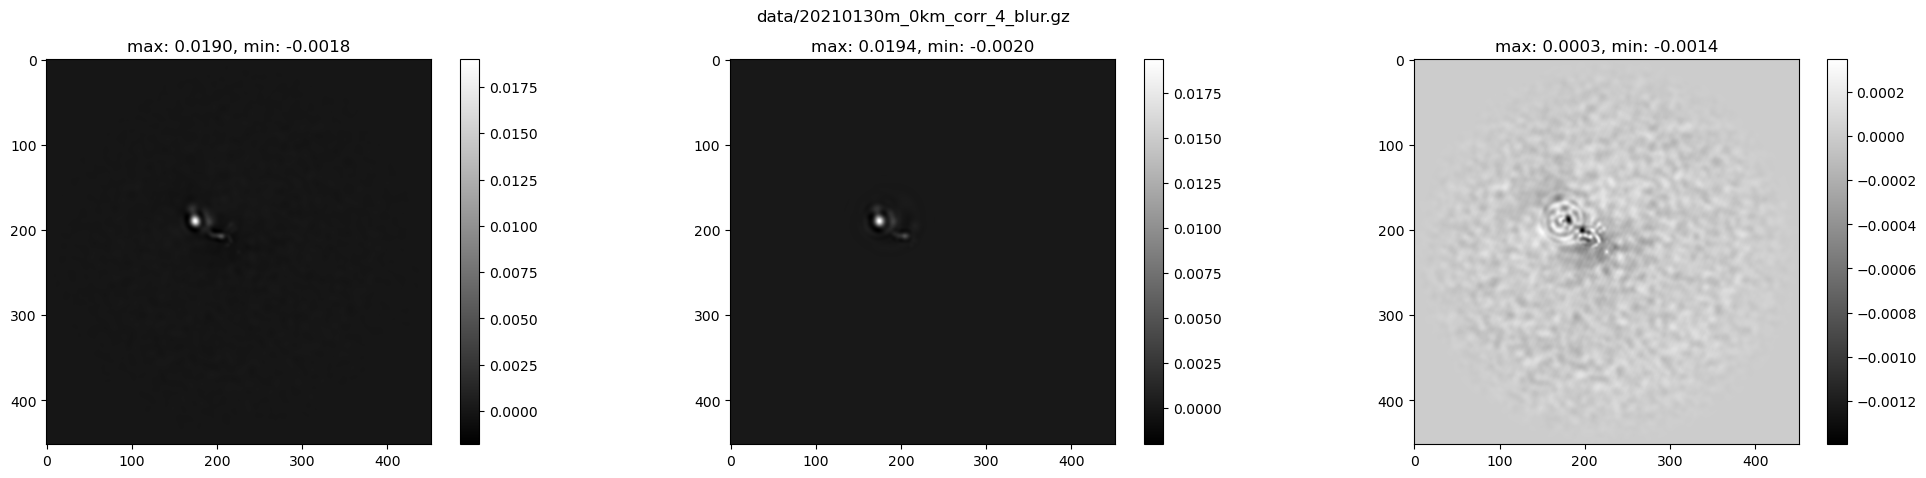

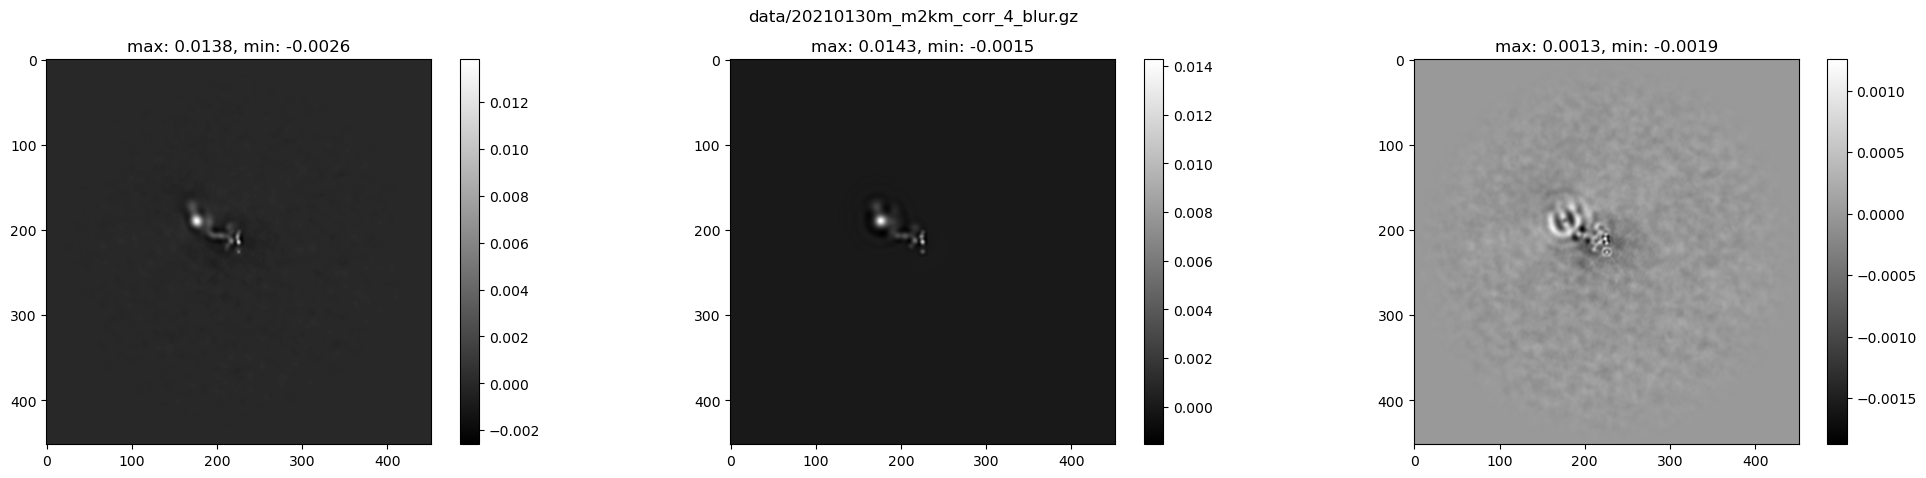

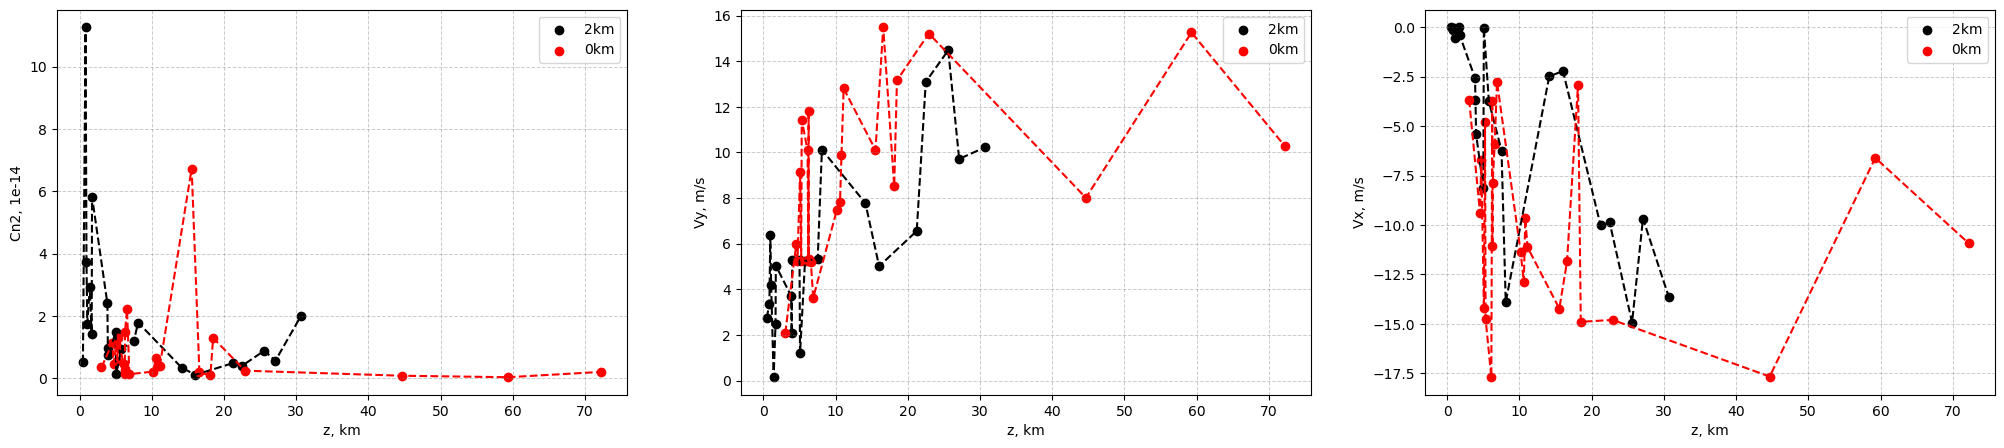

In [2]:
from clean import curvef

curvef(file='data/20210130m_m2km_corr_4_blur.gz',
       file2='data/20210130m_0km_corr_4_blur.gz',
       mode='blur', 
       D=2.5, 
       latency=4, 
       sec_per_frame=0.01, 
       dist0=2, # нужно для отрисовки профиля, отнимается от file
       dist02=0,
       gain=1, 
       thresh_manual=0, 
       thresh_manual2=-0.001,
       niter=50, 
       window=15,
       run_clean='yes',
       checkpointf='no', 
       step=None,
       seeing_lambda=500*pow(10, -9),
       data_dir='D:/astro/domecam')

# сделать сортировку в err по индексам из обычных дат. и после этого уже включить сброс индексов, чтобы они по порядку 
# отображались
# посмотреть, есть ли в настройках curve_fit параметр количетсва иттераций